<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 11 Day 1</div>
<div style="text-align: right">Dino Konstantopoulos, 17 November 2020, with material by Thomas Wiecki</div>

# Metropolis explained

This is a lab on the [Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm). The Metropolis algorithm ushered in a new era for statistics, built on computer simulations rather than math.

## The Math

In the philosophy of decision making, **Bayesian inference** manipulates **priors**, **evidence**, and **likelihood** to compute the **posterior**. 

Given some event $A_1$, what is the probability that event $A_2$ occurs if you know the converse?

This is answered by [Bayes' formula](https://en.wikipedia.org/wiki/Bayes%27_theorem): $P(A_2|A_1)=\dfrac{P(A_1|A_2)P(A_2)}{P(A_1)}$

* $P(A_2|A_1)$ is the **posterior**. What we wish to compute.

* $P(A_1|A_2)$ is the **likelihood**. Assuming $A_2$ occured, how likely is $A_1$. When we build a model by looking at the histogram of our observations and we assume a pdf, this is what we assume: the likelihood.

* $P(A_2)$ is the **prior**. How likely the event $A_2$ is regardless of evidence.

* $P(A_1)$ is the **evidence**. How likely $A_1$ is regardless of any events.

In our case, we are interested in this specific formulation of Bayes' formula, which relates observations $D$ ($D$ for data) to model parameters $\theta$:If we observe the data $D$, what are our model parameters $\theta$?

$P(\theta|D)=\dfrac{P(D|\theta)P(\theta)}{P(D)}$ where, $P(\theta|D)$ is the **posterior**, $P(D|\theta)$ is the **likelihood**, $P(\theta)$ is the **prior** and $P(D)$ is the **evidence**.

## Frequentist vs Bayesian thinking

There are two major interpretations to probabilities: **Bayesian** and **Frequentist**. 

We began our class with a **Frequentist's** perspective: Probabilities represent long term frequencies with which events occur: number of favorable events over number of all possible events. A frequentist says that the probability of having **tails** from a coin toss is equal to 0.5 *on the long run*. 

Each new experiment, a **Bernoulli trial**, can be considered as one of an infinite sequence of possible repetitions of the same experiment. The idea is that there is ***no belief*** in a frequentist's view of probability. The probability of event $x$ happening out of $n$ trials is equal to the following frequency: $p(x)=\dfrac{\text{number of $x$'s}}{n}$, and the true probability is reached when $n->\infty$. 

Frequentists will never say ***I am 75% (0.75) sure that Lewis Hamilton will win the 2019 F1 season*** before the season ends. When the season ends, they can say Lewis Hamilton has a probability of winning a F1 season equal to the number of points he won over the number of total points awarded in 2019, but even that is a stretch for a frequentist because he has to repeat the experiment over all possible F1 seasons that include LH. Commonly, a frequentist approach is referred to as the **objective** approach since there is no expression of belief.

On the other hand, in **Bayesian** thinking, probabilities are treated as an expression of **belief**. Therefore it is perfectly reasonable for a Bayesian to say ***I am 75% sure that Lewis Hamilton will win the 2019 F1 season***. By combining **prior** beliefs and current events (the **evidence**) one can compute the **posterior**, the belief that Lewis Hamilton will win the 2019 F1 season. 

We had a prior belief about how infectious Covid19 (not worse than the flu), but now we have new evidence and a new belief about the infectivity of the virus (much worse than the flu). The idea behind Bayesian thinking is to keep ***updating*** our beliefs as more evidence is provided. Since this approach deals with belief, it is usually referred to as the **subjective** view on probability.

## The difficulty in Bayes' Formula: The denominator

The **prior** $P(\theta)$ in our formula above is what you believe about ***parameters in your model***. For example, how fair are the two dice, how much do you believe in the power of the Hamilton (btw, he won the 2020 season for a record 7th time!!), etc. Then you get some **evidence**, such as dice rolls and F1 wins, and your belief about the parameter gets updated, sometimes reinforced, sometimes not. 

MCMC algorithms like the [Metropolis algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) takes in your model (probability) for the dependent variable $y$ of your data *conditioned* on a parameter $\theta$, called the **likelihood**, your model (probability) for the parameter(s) $\theta$ called the **prior**, and given the **evidence** (probability) that the data $y$ was indeed generated by your model, builds an updated belief (probability) about the parameter $\theta$ (the **posterior**):

$$p(\theta\;|\;y) = \frac{p(y\;|\;\theta) \;p(\theta)}{p(y)}$$

Our **posterior**, $p(\theta\;|\;y)$, is the probability for our model parameter $\theta$ conditioned on the observations, i.e. the dependent variable $y$ ($y$ is a **vector** for discrete random variables that is usually given by a probability distribution in the form of a dictionary, and a **function** for continuous random variables usually given by a function definition but could also be approximated by a dictionary). 

To compute our **posterior**, we multiply the **prior** $p(\theta)$ (what we think about $\theta$ before we see any observations) with the **likelihood** $p(y\;|\;\theta)$, which is how we think our data is distributed. Then we divide by something...

That something, $p(y)$, is called the **evidence**: Evidence that the data $y$ was indeed generated by your model. This quantity is conditioned on ***all possible values of our parameter*** $\theta$. 

For continuous variables, we compute this quantity by *integrating* over all possible parameter values:

$$p(y) = \int_\theta p(y, \theta) \, \mathrm{d}\theta$$

For discrete variables, we compute this quantity by *summing* over all possible parameter values:

$$p(y) = \sum_\theta p(y, \theta)$$

Heym that is ***tough*** to compute! It's is the key difficulty with Bayes formula: For even slightly non-trivial models ***you cannot compute the posterior in a closed-form way***. It's much like our MLE lab: We have to employ numerical methods like gradient descent.

## An approximation then?

There exist a class of algorithms called [**Markov chain Monte Carlo**](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) that construct a **Markov chain** (where each step in state space is memoryless) to do a **Monte Carlo** (use a random variable like a coin) approximation for the solution, in much the same way you worked your "**The One**" homework: By blind search.

## Generating some data

Lets generate 100 points from a normal distribution with a zero mean. Then, we'll assume we do not know how the data was generated. In other words, ee'll seed our model with an uninformative prior. Our goal will be to estimate the posterior of the mean `mu` (we'll assume that we know the standard deviation to be 1). 

We know we start with a zero mean, so we know what we should end up with, if our reasoning is correct!

In [33]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

Numpy's `random.randn()` generates random variates according to a **normal** distribution. This is what the $y$'s look like. Run the cell below many times to see that, indeed, you get random-looking data.

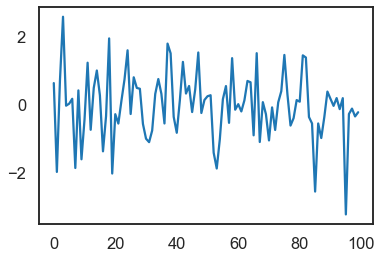

In [7]:
data = np.random.randn(100)
plt.plot(data)

..and yet, even though the data is random, the histogram of the data reveals that some values $y$ happen **more often** than others. 

It's the same with your emails. Sometimes you receive 0 emails, sometimes 100 in a day. But most of the time, you receive.. a dozen! You know your emails are Poisson-distributed, but here we have a normal distribution.

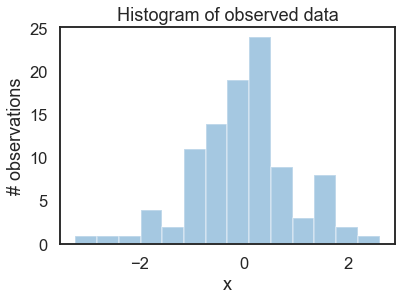

In [8]:
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

## An analytic solution for gaussians

We will assume we did not know how the data was generated. But by looking at the histogram above, we can assume that the data is **normally** distributed, i.e. the **likelihood** of the model is **normal**. 

As you know, a normal distribution has two parameters **mean** $\mu$ and **standard deviation** $\sigma$. For simplicity, we'll assume we know that $\sigma = 1$ and we want to infer the posterior for $\mu$. 

In Bayesian estimation, to infer a parameter we have to give it a pdf. Specifically, a **prior**. For simplicity, let's also assume a normal distribution as a prior for $\mu$. Thus, in statistical speak our model for prior and likelihood is:

$$p(\mu) = \text{Normal}(0, 1)\\
p(y\;|\;\mu) = \text{Normal}(y; \mu, 1)$$

What is convenient is that for this model, we can actually compute the posterior **analytically**. That's because for a normal likelihood with known standard deviation, the normal prior for `mu` is [**conjugate**](https://en.wikipedia.org/wiki/Conjugate_prior). **Conjugate** means that your posterior will follow the ***same*** distribution as your prior, so we know that our posterior for $\mu$ is ***also normal***. 

You can look up on wikipedia how we can compute the parameters of the posterior. For a mathematical derivation, see [here](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxiYXllc2VjdHxneDplNGY0MDljNDA5MGYxYTM). So here's the analytic solution.

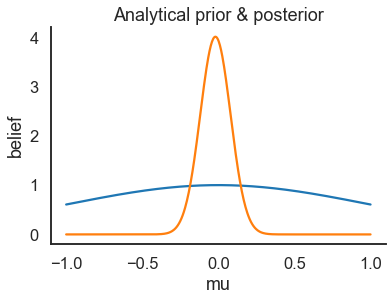

In [34]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
prior_analytical = gaussian(x, 0., 1.)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, prior_analytical)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical prior & posterior');
sns.despine()

 So that's the probability of $\mu$'s values after having seen the data, taking our prior information into account. We started with a gaussian centered at 0 with a wide standard deviation, and our posterior is also centered around 0 with a *smaller* standard deviation, reflecting our posterior belief that we are ***more sure that `mu` is close to zero***.
 
But.. what if we're not good at math?

## Writing a program

So we're not good at math. What to do? We're in parameter space (the 2D space $(\mu, \sigma)$) and looking for a solution for $\mu$ and $\sigma$, much like you're in genome space, looking for a solution for sexy 42.

Let's fix $\sigma$ and only worry about $\mu$. 

Let's ***guess*** the first value of $\mu$, then use a program that generates **random variables** (Monte Carlo) to guess another value, *and so on*. Kind of like the same way we guess new chromosomes through reproduction and mutation.

```python
mu_current = 1.
```

But how to move in parameter space? You propose to move (jump) from one position, the *current* position in parameter state space  ***randomly*** (that's the **Monte Carlo** part, which gets rid of *bias*) to *somewhere else*, the *proposed* position (the **Markov** part is you don't care about where you where before `mu_current`). 

<br />
<center>
<img src="ipynb.images/hopscotch.jpg" width=700 />
</center>

You can be very dumb or very sophisticated about how you come up with your jumping proposal. The Metropolis **sampler** is very dumb and just takes a sample from a normal distribution (***no relationship to the normal we assume for our model***), centered around your current `mu` value (i.e. `mu_current`), and with a certain standard deviation (`proposal_width`) that will determine how far jumps are proposed. 

Yup, that's right, it's like rolling a die, only with a *biased* die whose pdf looks like a gaussian. You already did this homework, remember?

<br />
<center>
<img src="ipynb.images/roll-die.jpg" width=400 />
</center>

Let's use `scipy.stats.norm`:

```python
proposal = norm(mu_current, proposal_width).rvs()
```

Yup, that's right, instead of a genetic algorithm (GA) where we move *somewhat intelligently* to a new position in state space that increases fitness, we use a pdf that is a gaussian which will produce simple random variates with a certain distribution that will generate new values for our parameters. 

The most likely position will be to.. *stay where we are* (because the pdf is normal centered around the current value for the parameter), but other positions are possible! Including, with very small probability, all the way out to 3 standard deviations.

The next step is to evaluate whether that's a ***good place to jump to or not***. If the resulting normal distribution with that proposed new `mu` *explains* the data better than your old `mu_current`, you'll definitely want to go there. 

But what does ***explains the data better*** mean? We need some kind of fitness function, like in our ***The One*** hw. 

<br />
<center>
<img src="ipynb.images/jump-rope.jpeg" width=400 />
</center>

We quantify **fit** by computing the posterior probability that we observe the data, given the likelihood and prior, with the proposed parameter values (proposed new `mu` and fixed `sigma = 1`). 

How to do this?

This can be computed by calculating the probability for each individual observation $y$ using `scipy.stats.normal(mu, sigma).pdf(y)` and then multiplying all of them since we want to observe ***one data point after another***, like a succession of coin flips for which we know the result. That is how we compute the **likelihood**. 

Usually, you would use **log** probabilities to work with *sums* instead of *products* because sums overflow a lot less than products do, but we don't have to do this here because we only have 100 datapoints (actually, we will see we do end up in trouble and underflow to zero in our simulations, even with 100 datapoints).

Note that `.pdf(data)` returns a **vector**, and `v.prod()` takes the product of each element of `v` and this returns a **scalar** (a number).

Let's do this:

### before and after *Likelihoods*:
```python
likelihood_current = norm(mu_current, 1).pdf(data).prod()
likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
```
Note that `pdf(data)` yields a *vector*, and that taking its `.prod()` yields *one value*.

### before and after *priors*:    
```python
prior_current = norm(mu_current, 1).pdf(mu_current)
prior_proposal = norm(mu_proposal, 1).pdf(mu_proposal)
```
Note that `pdf(mu_current)` yields *one value* from that distribution.

### and so, before and after *nominators* in Bayes formula:
```python
p_current = likelihood_current * prior_current
p_proposal = likelihood_proposal * prior_proposal

```

So, we have a *hill-climbing* algorithm that would propose movements into random directions in state space (here, our state space is 1D since only one parameter is unknown) and only accept a jump if `mu_proposal` yields higher `p_proposal` than that of `mu_current`, which is `p_current`. 

Hopefully, eventually, we'll get to `mu = 0` (or close to it) from where no more moves will be possible because improvements won't be possible anymore. 

However, we don't want to be too *greedy*! We'll also have to sometimes accept moves into the **other direction** (yielding lower posterior). The key trick is by dividing the two probabilities above:

```python
p_accept = p_proposal / p_current
```

to get an **acceptance probability**. If `p_proposal` is larger, `p_accept` will be `> 1` and we'll ***definitely accept the move***. However, if `p_current` is larger, say twice as large, we'll say that there is only a 50% chance of moving there, and we ***move there with that probability in mind*** (we move there with a probaility of 50%, so sometimes we move and sometimes we don't). 

>**Analogy**: It's a bit like having an argument with your boyfriend/girlfriend. *You* know you're always right, but you can't be too greedy: Sometimes you know you have to *pretend* you're wrong. When to do that? Well how about when the dinner your boyfriend/girlfriend cooked is better than yours? If it's *half* as better, then you'll pretend you're wrong half of the times. If it's 30% better, then you'll pretend you're wrong 30% of the time  :-) That's because you wouldn't want to miss on a good dinner, would you?

<br />
<center>
<img src="ipynb.images/scheming-man.jpg" width=400 />
</center>

>Of course, your boyfriend/girlfriend's dinner can be up to 99% better, but not 100% or more better because we all know you're a pretty awesome cook, *too* (and that you're really right *all the time* ;-)

So the key predicate is:

```python
accept = np.random.rand() < p_accept

if accept:
    # Update position
    cur_pos = proposal

```
This simple procedure actually gives us samples from our posterior. In other words, it simulates the posterior we're after!
<left>
<img src="ipynb.images/minion-whaaat.png" width=100 />
</left>

## Why?
Well, this seems awfully simple, but this simple acceptance ratio is the reason this algorithm works out and we get around the difficult integration in the ***denominator*** of Bayes' formula. 

We can show this by computing the acceptance ratio over the *normalized posterior* (with denominator) and see how it's equivalent to the acceptance ratio of the *unnormalized posterior* (no denominator, what we called `p_proposal` and `p_current`).

Lets say $\mu_0$ is our current position, and $\mu$ is our proposal:

$$ \frac{\frac{p(y\;|\;\mu) \;p(\mu)}{p(y)}}{\frac{p(y\;|\;\mu_0) \;p(\mu_0)}{p(y)}} = \frac{p(y\;|\;\mu) \;p(\mu)}{p(y\;|\;\mu_0) \;p(\mu_0)}$$

So we see that dividing the posterior of the proposed parameter setting by the posterior of the current parameter setting, $p(y)$, ***that nasty denominator quantity we can't compute***, gets canceled out! 

So our algorithm is actually dividing the ***full*** posterior at *one position* by the ***full*** posterior *at another position*, and we're visiting regions of high posterior probability *relatively* more often than those of low posterior probability. So we're actually sampling from the posterior, without even having an analytic formula for the posterior! 

Regions of ***high*** posterior probability is where we want to sample ***more*** from because the model fits the observations better. Regions of ***low*** posterior probability is where we want to sample ***less*** from, but we still want to sample from according to the probability of getting that sample. And that is what Metropolis does! A simple brilliant little algorithm.

I highly recommend the same strategy with arguments with your boyfriend/girlfriend, conditioned on the probability of winning some prize, like a great dinner, or anything else he/she can provide! You will be sampling from your own curve of happiness: The happiness of being right *and* eating great food!

### Putting it all together

In [5]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    
    for i in range(samples):
        
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        # Compute Bayes' nominator
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

### Visualization

To visualize the sampling for $\mu$, we'll create plots for some quantities that are computed. Each row will be a single iteration through our Metropolis sampler. 

The first column is our **prior distribution**, what our belief about $\mu$ is before seeing the data. We cheat a little bit in the interest of convergence by starting with a pretty good guess since the peak is 0. So the distribution is static and we only plug in our $\mu$ proposals. The vertical lines represent our current $\mu$ in blue and our proposed $\mu$ in either red (if rejected) or green (if accepted). 

The 2nd column is our **likelihood distribution** and what we are using to evaluate how well our model explains the data (since we did not take logs, we multiply by 100 values less than 1, and sure enough we underflow to zero :-(). But you can see that the likelihood function changes in response to the proposed $\mu$. The blue histogram in the background is our data. The solid line in green or red is the likelihood with the currently proposed `mu`. Intuitively, the more overlap there is between likelihood and data, the better the model explains the data and the higher the resulting probability will be. The dotted line of the same color is the proposed `mu` and the dotted blue line is the current `mu`. 

The 3rd column is our **posterior distribution**. Here we display the normalized posterior but as we found out above, we can just multiply the prior value for the current and proposed $\mu$'s by the likelihood value for the two $\mu$'s to get the unnormalized posterior values (which we use for the actual computation), and divide one by the other to get our acceptance probability.

The 4th column is our **trace** (the posterior samples of $\mu$ we're generating) where we store each accepted sample (if the sample is not accepted the line just stays constant).

Note that the algorithm says that we ***always*** move to relatively more likely $\mu$ values (in terms of their posterior density), but ***only sometimes*** to relatively less likely $\mu$ values (iteration number can be found at the top center of each row).

In [35]:
# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # plot Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # plot Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

Let's set a random seed and sample 8 values of $\mu$ from our posterior. Our initial guess for the mean will be -1, just to make sure we start a bit far away from the true value of 0.

>**Note**: Please don't run the following cell so we can discuss about the *same* simulation. Since this algorithm is *probabilistic*, like ***The One***, we will get different results every time we run it (but since we set a *seed*, we should get the same different results successively).

d:\Anaconda3.5.1\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


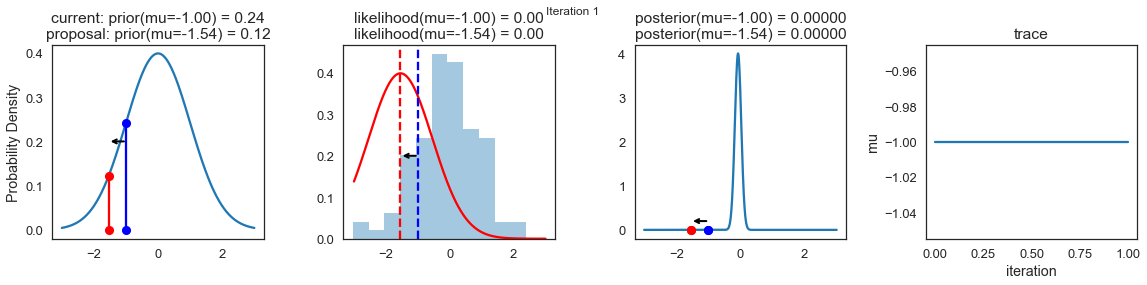

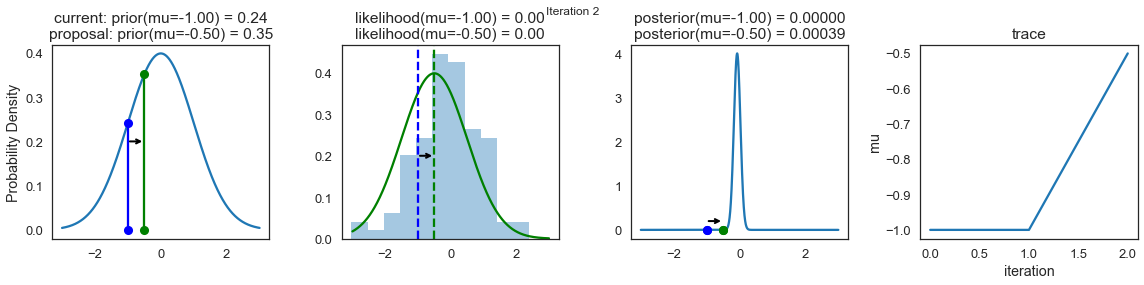

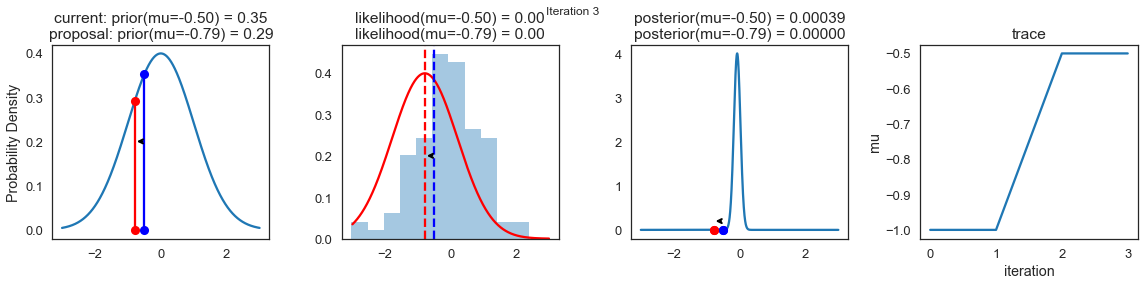

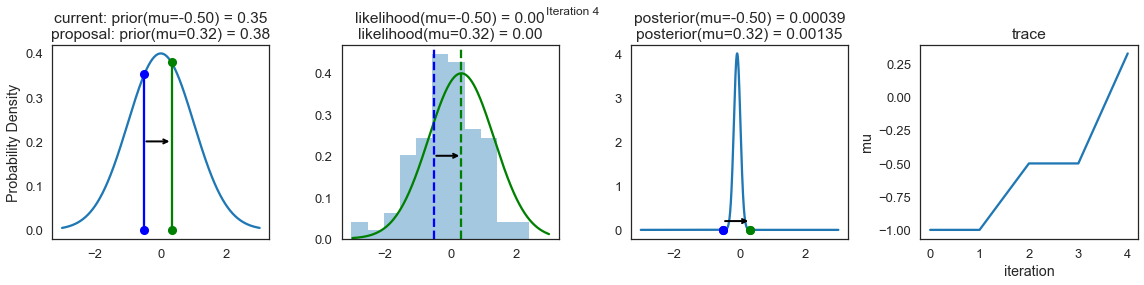

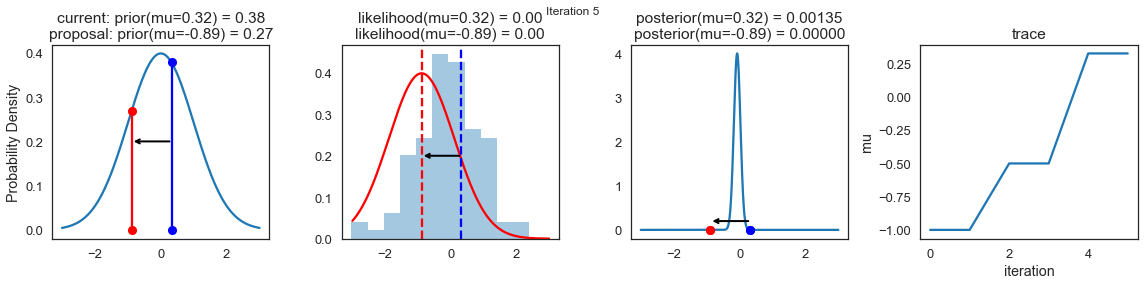

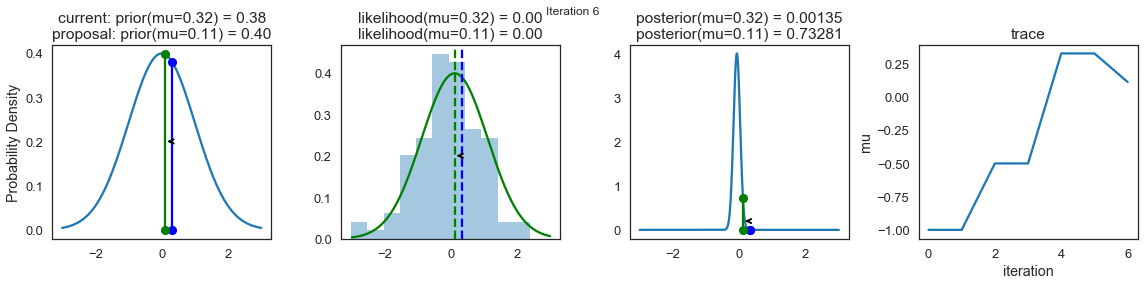

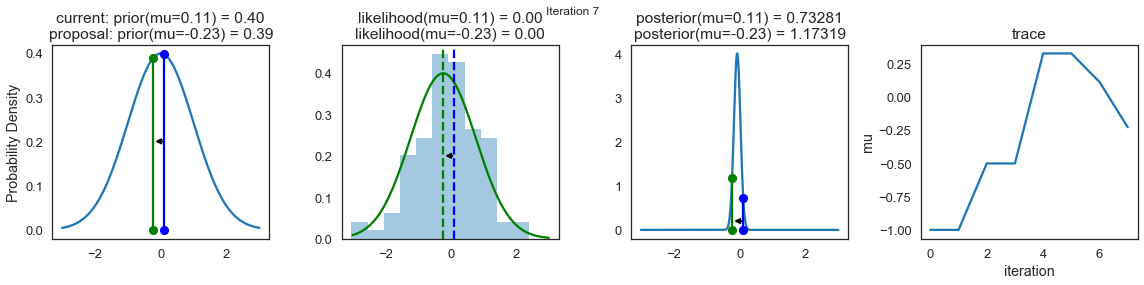

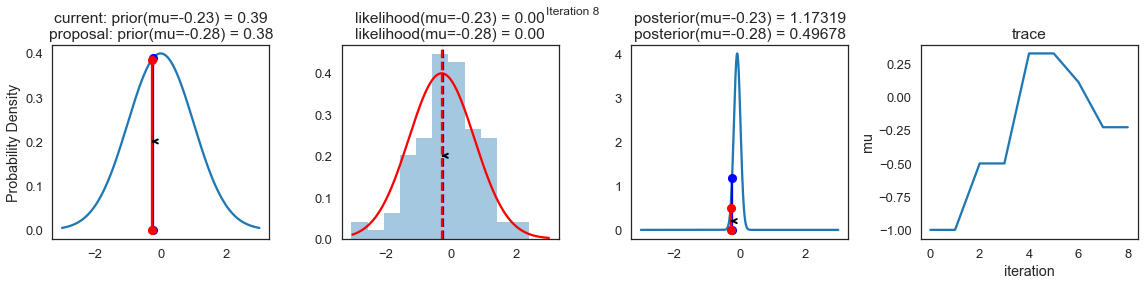

In [22]:
np.random.seed(123)
sampler(data, samples=8, mu_init=-1., plot=True);

We conducted 8 samplings, above. We know our optimal $\mu$ is 0, but *we pretend we don't know*. We start the simulation with $\mu = -1$. Our first sample leads to $\mu = -1.54$. It leads to a likelihood pdf that is *further away* to the true one (of course we don't know the true distribution of $\mu$, but since we have an analytic solution because we're good at math, we do know it so we can plot it), but it leads to a worse posterior, so we flip a coin and the coin decides not to move from the current $\mu = 1$ position.

In the next sampling, $\mu = -0.5$, we actually improve our posterior, so we *necessarily* accept the proposal and move.

In the 3rd sampling, $\mu = =0.79$, we worsen our posterior, we flip a coin, and the coin decides not to move from the current $\mu = 0.5$ position.

In the 4th sampling, we improve, so we accept the proposal and move to the new value $\mu = 0.32$.

In the 5th sampling, we worsen our posterior, so we flip a coin, and the coin decides for us not to move from the current position $\mu = 0.32$.

In the 6th sampling, $\mu = 0.11$, we improve our posterior, so we necessarily move to $\mu = 0.11$.

In the 7th sampling, $mu = -0.23$, we worsen our posterior, so we flip a coin, and... *the coin decides for us to move anyway*. That happens!

In the 8th sampling, we worsen, and the coin decides not move. So we finish our 8 samplings with the value $\mu = 0.23$

So, we *always* accept better proposals, and only *sometimes* accept worse proposals. And this is *key* to convergence to the optimal value because it helps us not to get *stuck* in gravity wells.

<left>
<img src="ipynb.images/gravity-well.jpg" width=500 />
</left>

Ok, now create a new cell here below, paste the simulation code, and rerun the simulation to look at different samplings.
```(python)
sampler(data, samples=8, mu_init=-1., plot=True);
```

To get a sense of what our sampler produces in general, lets draw a lot of samples and plot them (not the intermediate steps, just all the values of the parameter $\mu$ that we generate with the Metropolis algorithm:

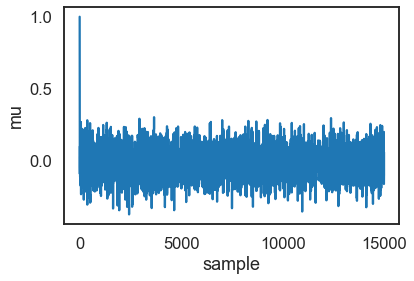

In [36]:
posterior = sampler(data, samples=15000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

This is usually called the **trace** of our simulation. 

To now get an **approximation** of the posterior (the reason why we're doing all this), we simply take the histogram of this trace, to see ***which values we generate more often***!. We also superimpose our analytic solution for the posterior, from way above in our notebook.

>**NOTE**: Which values we generate more often gets us closer to the the peak of the histogram, but this simulations also allows to sample all possible values so we can get a real histogram of our posterior distribution, which is *exactly what we're after* in Bayesian statistics.

It's important to keep in mind that although this may look similar to the **data** we sampled above to fit the model, the two are completely separate things: This represents simulations of our **belief** in `mu`. In this case it just happens to also be normally distributed, like our data. Pleeeeeease do not confuse these two gaussians!

For a different model, our belief could have a completely different shape than the likelihood or prior.

Now we plot the histogram for `mu`, and we superimpose the analytic solution we derived in the beginning of the notebook.

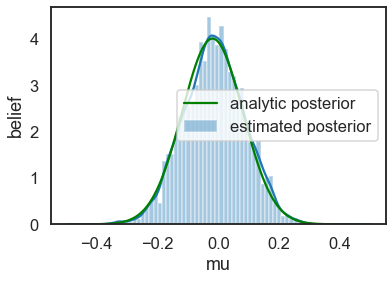

In [37]:
ax = plt.subplot()

sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();

What a nice match!

So you can see, by following the Metropolis algorithm, we get samples from the same distribution as the one we derived analytically.

Neat, huh? And we did this without being good at math.

<br />
<center>
    <img src="ipynb.images/Calvin_and_hobbes._teacher.gif" width=600 />
</center>

## Effect of the proposal width

Above in `def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.)`, we set the proposal width (the standard deviation of the normal distribution used to *guess* new values of `mu`) to `0.5`. 

That turned out to be a pretty good value. In general you don't want the width to be too narrow because your sampling will be inefficient as it takes a loooooooong time to explore the whole parameter space and exhibits typical random-walk behavior. It's like our **The One** hyperparameters: We want to pick the right mutation and reproduction rates that let us explore all genome space.

This is our original simulation trace:

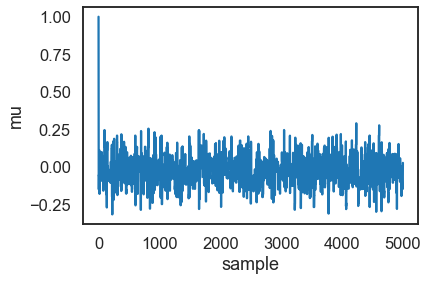

In [38]:
from scipy.stats import norm
posterior = sampler(data, samples=5000, mu_init=1., proposal_width=.5)
fig, ax = plt.subplots()
ax.plot(posterior);
_ = ax.set(xlabel='sample', ylabel='mu');

This is a simulation trace for an inordinately low proposal width of 0.01:

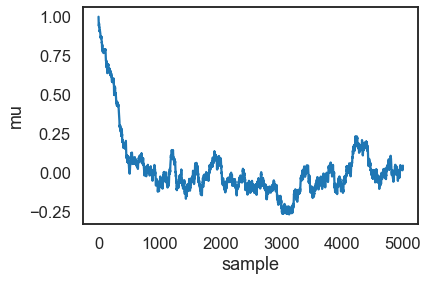

In [39]:
from scipy.stats import norm
posterior_small = sampler(data, samples=5000, mu_init=1., proposal_width=.01)
fig, ax = plt.subplots()
ax.plot(posterior_small);
_ = ax.set(xlabel='sample', ylabel='mu');

But you also don't want the proposal width to be so large that you would ***never accept a jump***.

This is a simulation trace for a proposal width that is too high:

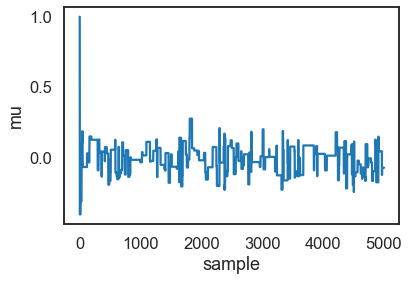

In [40]:
posterior_large = sampler(data, samples=5000, mu_init=1., proposal_width=3.)
fig, ax = plt.subplots()
ax.plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu');
_ = ax.set(xlabel='sample', ylabel='mu');

In both cases, you are still sampling from your target posterior distribution here as guaranteed by a mathematical proof, just ***less efficiently***. And you can see the result of this inefficiency leading to simulations that don't look very *random*.

>**Note**: This is why Roulette Wheel selection, a.k.a. Darwinian evolution, is the better strategy for maximizing fitness: It's the most efficient way of exploring *all of* state space to find the fittest possibilities. I think it's also true in the continuum of thinking: Best ideas are found when you allow your mind to be completely open so you can explore all possibilities, not just, for example, the possibilities handed out to you by your government. Democracies sometimes lead to worse situations, like president Trump for example. But we inevitably accept them because we posit that sometimes accepting worse situations is the *way that leads to better outcomes in the long run*. 

Let's compare the distributions we get with smaller than normal (too prudent), or bigger than normal (too risky) step sizes:

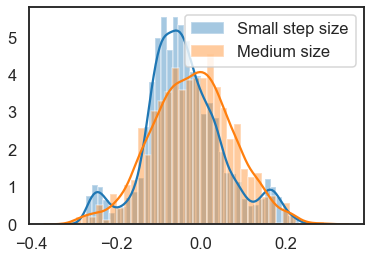

In [41]:
sns.distplot(posterior_small[1000:], label='Small step size')
sns.distplot(posterior[1000:], label='Medium size');
_ = plt.legend();

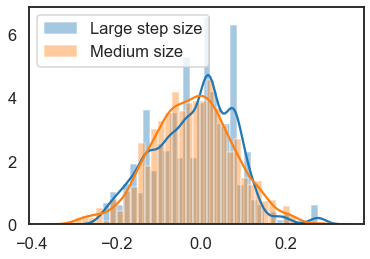

In [42]:
sns.distplot(posterior_large[1000:], label='Large step size')
sns.distplot(posterior[1000:], label='Medium size');
_ = plt.legend();

In both cases, we want the medium size!

With more and more samples, all distributions, irrespective of step size, will eventually look like the true posterior. 

The key is that we want our samples to be *independent of each other*, because this represents the greatest *freedom of exploration*.

Thus, one common metric to evaluate the efficiency of our sampler is **autocorrelation**, i.e. *how correlated a sample `i` is to sample `i-1`, `i-2`, etc.*

(pymc3's `autocorr` API is now in library `arviz`):

In [43]:
import pymc3
#from pymc3.stats import autocorr
from arviz import autocorr
autocorr(np.asarray(posterior_large), axis=-1)

array([ 1.        ,  0.91898449,  0.84223434, ..., -0.00206652,
       -0.0025656 , -0.0012828 ])

Hmm.. I don't grok `arviz`'s autocorrelation function, so here's my own autocorrelation function with step size:

In [31]:
def my_autocorr(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))

my_autocorr(posterior_large, 4)

array([[1.        , 0.73805008],
       [0.73805008, 1.        ]])

And because `numpy` gives me a matrix instead of a value, I will take the 2nd column of the first row: `[0,1]`,

So this is autocorrelation of the three posteriors as a function of step size:

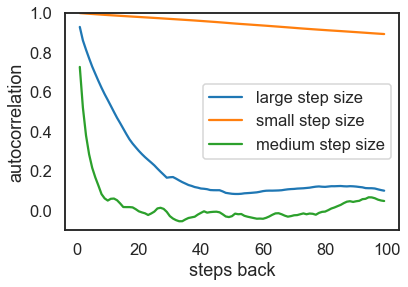

In [44]:
import pymc3
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from pymc3.stats import autocorr
#from arviz import autocorr
steps_back = range(1,100)
fig, ax = plt.subplots()

ax.plot(steps_back, [my_autocorr(posterior_large, l)[0,1] for l in steps_back], label='large step size')
ax.plot(steps_back, [my_autocorr(posterior_small, l)[0,1] for l in steps_back], label='small step size')
ax.plot(steps_back, [my_autocorr(posterior, l)[0,1] for l in steps_back], label='medium step size')
ax.legend(loc=0)
_ = ax.set(xlabel='steps back', ylabel='autocorrelation', ylim=(-.1, 1))

This shows that medium step size converges faster, because autocorrelation gets lower faster, so that maximizes freedomg of exploration.

>**NOTE**: What's a smart way of figuring out the right step width automatically? One commonly used method is to keep adjusting proposal width so that roughly 50% proposals are rejected.

## Extending to more complex models

Now you can imagine that we could also add a `sigma` parameter for the standard-deviation and follow the same procedure for this second parameter. 

In that case, we would be generating proposals for `mu` *and* `sigma` so that our state space would be 2D, but the algorithm logic would be identical. 

We could also have data from a very different distribution of our data, like a Binomial, and still use the same algorithm and get the correct posterior! That's pretty cool and a huge benefit of probabilistic programming: Just define the model you want and let MCMC take care of the inference.

For example, the below model can be written in `PyMC3` quite easily. Below we also use the Metropolis sampler (which automatically tunes the proposal width) and see that we get identical results. 

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 62000/62000 [00:49<00:00, 1240.39draws/s]
The number of effective samples is smaller than 25% for some parameters.


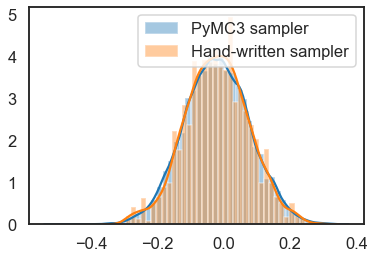

In [45]:
import seaborn as sns
import pymc3 as pm

with pm.Model():
    mu = pm.Normal('mu', 0, 1)
    sigma = 1.
    returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data)
    
    step = pm.Metropolis()
    trace = pm.sample(15000, step)
    
sns.distplot(trace[2000:]['mu'], label='PyMC3 sampler');
sns.distplot(posterior[500:], label='Hand-written sampler');
plt.legend();

# Conclusion

A simple algorithm that relies on a chain of random processes and on a semi-intelligent procedure for whether to accept the new random value or not based on model likelihood estimates actually samples (i.e. generates variates) from an unknown and difficult to compute posterior distribution.

This is what you're doing when you're programming with `PyMC3`.

Also a simple model for married bliss ;-)

Bayesian estimation allows us to build a model for observations ***and to refine this model based on new evidence*** and generate random variates (from a posterior pdf) that take this new evidence into account. 

We can now estimate the probability of a Lewis Hamilton win at any point in time of the F1 season, based on how he's actually doing throughout the season. In the case of F1, the number of datapoints is small and we may want to store complete probability distributions in the form of dicitonaries, as our model. 

When we have continuous variables, or when we have many many datapoints as in the case of our Covid19 model, building a **Bayesian model** is an act of dimensionality reduction. Your brain loves that. And so do machines. 

In my opinion, in AI research, we focus too much on building very complex data-intense ***single-focus*** programs with large ML frameworks like tensorflow, instead of building many simpler bayesian models and then putting them to work all together. That is what our brains are: many many low-dimensional models put together so that we can better predict life and plan for happiness. That is how we should build robots too: Learn by observing many different data and try to build many many little independent models for each data type (walking, seeing, social interactions, etc.), that work with each other.